# Question 1

In [41]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, classification_report
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.sparse import isspmatrix
from sklearn import preprocessing
from scipy.stats import norm, skew
import numpy as np
%matplotlib inline

In [2]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')

We can see there are both categorical and continuous data in the data set

In [3]:
train_set.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


SalePrice is our target variable and therefore we remove it from the train set and put it in a separate y_train df.

In [4]:
y_train = train_set[['SalePrice']]
train_set = train_set.drop(['SalePrice'], axis=1)

With a first look at the dataset we can observe categorical data and missing values expressed in NaN. We need to fix them before proceeding with the prediction. Specifically, transform categorical data to dummy values and fill NaN values with 0 if we have numerical data or Other if we have categorical. Since we need to fix both train and test set it makes sence to merge into a dataframe and then separate them once more.

In [5]:
train_test_data =  pd.concat((train_set.loc[:,'MSSubClass':'SaleCondition'], test_set.loc[:, 'MSSubClass':'SaleCondition']))

In [6]:
numeric_feats = []
for col in train_test_data.columns:
    if train_test_data[col].dtype== np.float64:
        train_test_data[col]= train_test_data[col].fillna(0)
        numeric_feats.append(col)
    elif train_test_data[col].dtype == np.object:
        train_test_data[col] = train_test_data[col].fillna('Other')

We should also plot the target variable to check for skewness and if normalization is needed.

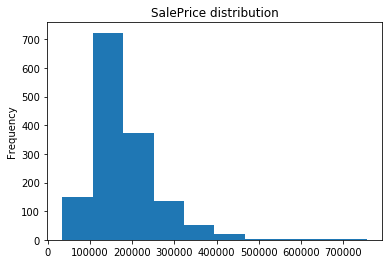

In [7]:
plt.hist(y_train['SalePrice'])
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

We can observe that the sale price variable is positively skewed since the blue line is deviated towards the right which means there is assymetry in the distribution and therefore we need to fix it to be normally distributed. To do so the best fix is to perform a log transform in the sales price and the features that suffer from skewness as well.

In [8]:
skewness = train_test_data[numeric_feats].skew()
# skew values over 1.00 and below -1.00 indicate substantial skewness 
skewness = skewness[(skewness>1.00)].index
train_test_data[skewness] = np.log1p(train_test_data[skewness])
y_train['SalePrice']= np.log1p(y_train['SalePrice'])

In [9]:
train_test_data['MSSubClass'] = train_test_data['MSSubClass'].astype('category')
train_test_data['OverallQual'] = train_test_data['OverallQual'].astype('category')
train_test_data['OverallCond'] = train_test_data['OverallCond'].astype('category')

In [10]:
train_test_data = pd.get_dummies(train_test_data)

In [11]:
x_train = train_test_data[:train_set.shape[0]]
x_test = train_test_data[train_set.shape[0]:]

Below we can see the correlation matrix. We can see a large number of features are correlated more than 60%

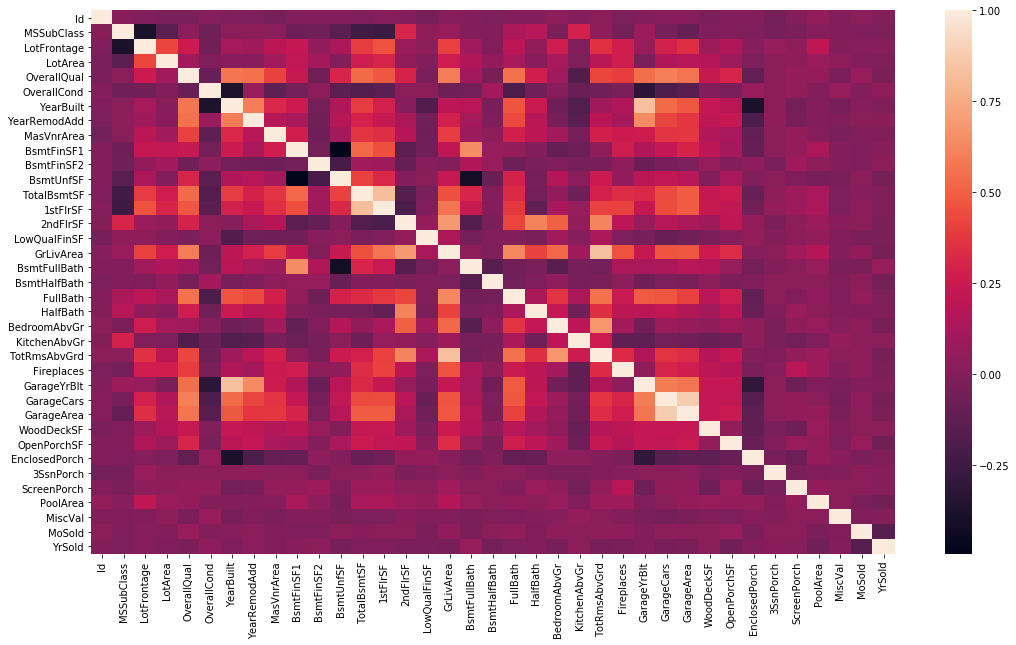

In [12]:
plt.figure(figsize=(18,10))
sns.heatmap(train_set.corr())

Let's now test the sparsity of the dataset

In [13]:
print ('The percentage of non-zeros elements is {0}'.format(np.count_nonzero(x_train)/np.size(x_train)))

The percentage of non-zeros elements is 0.19552190979732437


We will go ahead and perfom PCA so as to deal with correlated features and sparsity and therefore improve performance. 

In [14]:
pca = PCA(n_components=200)
X_train = pca.fit_transform(x_train)
X_test = pca.fit_transform(x_test)

## Models

In [55]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score

## Linear Regression

In [16]:
X_tr, X_tst, y_tr, y_tst = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
linreg = linear_model.LinearRegression()
linreg.fit(X_tr, y_tr)
y_pred = linreg.predict(X_tst)
score = cross_val_score(linreg, X_tr, y_tr).mean()
print("Linear Regression r2 score",r2_score(y_tst, y_pred))
print("Cross validation = %.2f" % score)

Linear Regression r2 score 0.8346284058658805
Cross validation = 0.86


## XGBoost Regressor

XGBoost is a Gradient Boosting algorithm, as its name gives away(short for extreme gradient boosting). The final values of the parameters were chosen using grid search with cross validation on 5 folds but also with tuning after some trials.  

In [22]:
X_tr, X_tst, y_tr, y_tst = train_test_split(x_train, y_train, test_size=0.3, random_state=0)
param_grid = { 
            "n_estimators"      : [50, 100],
           "max_depth"         : [2,3,5]}
GS_xgb = GridSearchCV(xgb.XGBRegressor(), param_grid=param_grid, cv= 5)
GS_xgb .fit(X_tr, y_tr)
print (GS_xgb.best_params_)

{'n_estimators': 100, 'max_depth': 3}


In [25]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=5)
xgb_model.fit(X_tr,y_tr)
y_pred = xgb_model.predict(X_tst)
score = cross_val_score(xgb_model, X_tr, y_tr).mean()
print("XGBoost accuracy score",r2_score(y_tst, y_pred))
print("Cross validation = %.2f" % score)

XGBoost accuracy score 0.8927202984913837
Cross validation = 0.88


## RandomForest Regressor

We perform grid search to find the best parameters for the random forest regressor model and cross validate them in 5 folds. 

In [26]:
X_tr, X_tst, y_tr, y_tst = train_test_split(x_train, y_train, test_size=0.3, random_state=0) 
param_grid = { 
            "n_estimators"      : [250, 500],
           "max_features"      : [3, 5],
           "max_depth"         : [3, 20],
           "min_samples_split" : [2, 4] ,
           "bootstrap": [True, False]}

CV_rfc = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv= 5)
CV_rfc.fit(X_tr, y_tr)
print (CV_rfc.best_params_)

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/cross_validation.py:1675: DataCon

{'max_features': 5, 'min_samples_split': 2, 'bootstrap': False, 'n_estimators': 250, 'max_depth': 20}


In [ ]:
rfc = RandomForestRegressor(random_state=0, n_estimators=500, max_depth=20, max_features=5, min_samples_split=2, bootstrap=False)
score = cross_val_score(rfc, X_tr, y_tr).mean()
print("Cross validation = %.2f" % score)
print("R2 Score= %.2f " %r2_score(y_pred, y_tst))

XGBoost presents the highest r2 score and performs better in cross validation in comparison to the other models. However all three models achieve scores higher than 0.80 which I consider to be due to the good preprocessing of the features. Moreover, room for improvement exists since other than preprocessing,  feature selection could also enhance the performance of the models.  

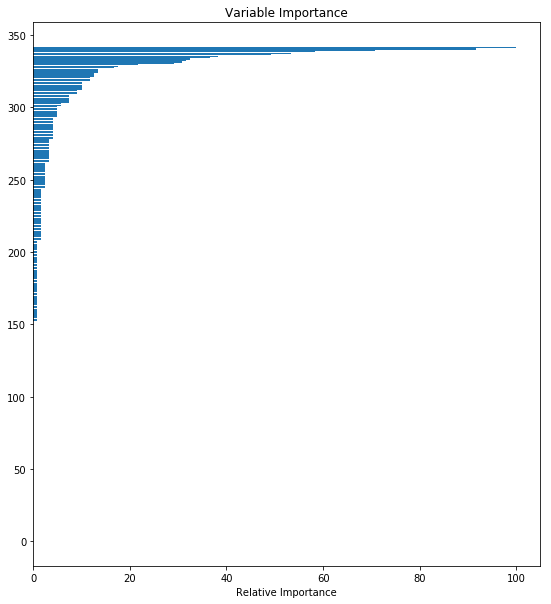

In [27]:
feature_importance =xgb_model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [28]:
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], feature_importance[indices[f]]))


Feature ranking:
1. feature 0 (100.000000)
2. feature 1 (91.666672)
3. feature 12 (70.833328)
4. feature 2 (58.333332)
5. feature 7 (53.333328)
6. feature 8 (49.166660)
7. feature 5 (38.333332)
8. feature 9 (36.666664)
9. feature 21 (32.500000)
10. feature 3 (31.666666)
11. feature 23 (30.833330)
12. feature 31 (29.166666)
13. feature 25 (21.666666)
14. feature 24 (17.500000)
15. feature 4 (16.666668)
16. feature 17 (13.333332)
17. feature 150 (13.333332)
18. feature 146 (13.333332)
19. feature 20 (12.500000)
20. feature 279 (12.500000)
21. feature 26 (12.500000)
22. feature 13 (11.666667)
23. feature 10 (11.666667)
24. feature 32 (11.666667)
25. feature 85 (9.999999)
26. feature 148 (9.999999)
27. feature 147 (9.999999)
28. feature 140 (9.999999)
29. feature 106 (9.999999)
30. feature 49 (9.999999)
31. feature 267 (9.166666)
32. feature 19 (9.166666)
33. feature 336 (9.166666)
34. feature 138 (7.500000)
35. feature 18 (7.500000)
36. feature 22 (7.500000)
37. feature 15 (7.500000)
38. 

As we can see from the bar chart of the relative feature importances and the ranking, while the first 11 features are contributing the most in the model after the 25th rank features have small contribution and in the last 10  positions features are worthless and not used in the model at all.

Finally we train the best model with the entire dataset but since we do not have the test sets true sales prices we cannot evaluate our model.

In [33]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=5)
xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_test)

# Question 2

In [29]:
forest_df = pd.read_csv('data/covtype.csv')

In [30]:
y = forest_df['Cover_Type']
X = forest_df.loc[:,'Elevation':'Soil_Type40']

In order to divide the dataset into X_train with 20000 examples and X_test with another 20000 we use StratifiedShuffleSplit from sklearn to split the set making sure through stratification that the classes ratio will be maintained. 

In [31]:
s = StratifiedShuffleSplit(n_splits=1, train_size=20000, test_size=20000, random_state=0)
for train_index, test_index in s.split(X,y):
    train_indices, test_indices = train_index , test_index
X_train = X.iloc[train_indices]
y_train = y[train_indices]
X_test = X.iloc[test_indices]
y_test = y[test_indices]

Logistic Regression classifier needs the features to be scaled in order to perform better so we use preprocessing scale module from sklearn. Also we train test split the train set in order to check the performance of our classifiers before evaluating in the test set. We once again use stratification in order to maintain class ratio.

In [46]:
X_train_scale = preprocessing.scale(X_train)
X_test_scale = preprocessing.scale(X_test)
X_tr_s , X_tst_s, y_tr_s, y_tst_s = train_test_split(X_train_scale, y_train, test_size=0.4, stratify=y_train)
X_tr, X_tst, y_tr, y_tst = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)


## Logistic Regression classifier

Using grid search to select best parameters for the logistic regression classifier

In [42]:
param_grid = {"solver" : ['newton-cg', 'lbfgs'],
              'multi_class' : ['ovr', 'multinomial'],
              "max_iter": [100, 200 , 300]}
# run grid search
grid_logreg = GridSearchCV(LogisticRegression(C= 0.00001), param_grid=param_grid)
grid_logreg.fit(X_tr_s, y_tr_s)
print("The best parameters are %s with a score of %0.2f"
     % (grid_logreg.best_params_, grid_logreg.best_score_))

The best parameters are {'multi_class': 'ovr', 'max_iter': 100, 'solver': 'newton-cg'} with a score of 0.49


In [47]:
logreg = LogisticRegression(C= 0.0001, multi_class='ovr')
logreg.fit(X_tr_s, y_tr_s)
y_pred_logreg = logreg.predict(X_tst_s)
print('Logistic regression accuracy score: ', accuracy_score(y_tst_s, y_pred_logreg))
print('Logistic regression classification report:\n', classification_report(y_tst_s, y_pred_logreg))

Logistic regression accuracy score:  0.665
Logistic regression classification report:
              precision    recall  f1-score   support

          1       0.67      0.61      0.64      2917
          2       0.70      0.79      0.74      3901
          3       0.51      0.96      0.67       492
          4       0.00      0.00      0.00        38
          5       0.00      0.00      0.00       131
          6       1.00      0.02      0.03       239
          7       1.00      0.01      0.02       282

avg / total       0.68      0.67      0.63      8000



/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest classifier


Once again we perform grid search to find the best parameters 

In [39]:
param_grid = {"max_depth": [3, 5, 7, 9],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
grid.fit(X_tr, y_tr)
print("The best parameters are %s with a score of %0.2f"
     % (grid.best_params_, grid.best_score_))

The best parameters are {'criterion': 'entropy', 'bootstrap': False, 'max_depth': 9} with a score of 0.73


In [48]:
rfc = RandomForestClassifier(max_depth=9, bootstrap=False, criterion='entropy', n_estimators=200)
rfc.fit(X_tr, y_tr)
y_pred_rfc = rfc.predict(X_tst)
print('Random forest accuracy score: ', accuracy_score(y_tst, y_pred_rfc))
print('Random forest classification report:\n', classification_report(y_tst, y_pred_rfc))

Random forest accuracy score:  0.7468333333333333
Random forest classification report:
              precision    recall  f1-score   support

          1       0.74      0.73      0.73      2188
          2       0.76      0.84      0.80      2926
          3       0.70      0.86      0.77       369
          4       0.40      0.14      0.21        28
          5       0.80      0.04      0.08        98
          6       0.59      0.11      0.19       179
          7       0.94      0.40      0.56       212

avg / total       0.75      0.75      0.73      6000



## XGBoost Classifier

In [49]:
param_grid = { "n_estimators"      : [50, 100],
           "max_depth"         : [2,3,5]}
GS_xgb = GridSearchCV(xgb.XGBClassifier(), param_grid=param_grid, cv= 5)
GS_xgb .fit(X_tr, y_tr)
print (GS_xgb.best_params_)

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWar

/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'n_estimators': 100, 'max_depth': 5}


In [57]:
xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1)
xgb.fit(X_tr, y_tr)
y_pred_xgb = xgb.predict(X_tst)
print('Xgboost accuracy score: ', accuracy_score(y_tst, y_pred_xgb))
print('Xgboostt classification report:\n', classification_report(y_tst, y_pred_xgb))

Xgboost accuracy score:  0.776
Xgboostt classification report:
              precision    recall  f1-score   support

          1       0.77      0.76      0.76      2188
          2       0.79      0.83      0.81      2926
          3       0.75      0.85      0.80       369
          4       0.69      0.64      0.67        28
          5       0.63      0.19      0.30        98
          6       0.53      0.35      0.42       179
          7       0.85      0.72      0.78       212

avg / total       0.77      0.78      0.77      6000



/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Again XGBoost classifier gives the best results in accuracy score as well as in the other metrics. From the classification report we can deduct that precision and recall scores are balanced in all models and approximately equal to the accuracy score. 

## Evaluation on X_test

In [58]:
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('Xgboost accuracy score: ', accuracy_score(y_test, y_pred_xgb))

Xgboost accuracy score:  0.7739


/home/vasia/miniconda2/envs/p3env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost gives the same accuracy score when evaluating the test set which means that the model is not overfitting the train dataset. Improvement could be possibly achieved should we perform feature selection. 

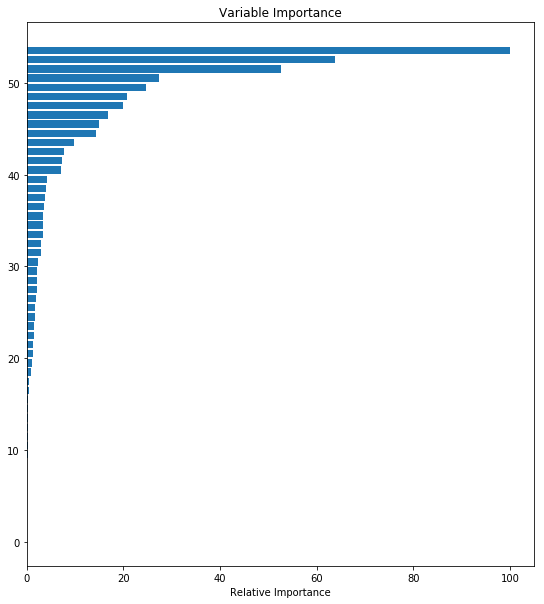

In [61]:
feature_importance =xgb_model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [62]:
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], feature_importance[indices[f]]))

Feature ranking:
1. feature 0 (100.000000)
2. feature 5 (63.712376)
3. feature 9 (52.508362)
4. feature 3 (27.424749)
5. feature 1 (24.581940)
6. feature 4 (20.735785)
7. feature 6 (19.899664)
8. feature 2 (16.889633)
9. feature 8 (14.882943)
10. feature 7 (14.381271)
11. feature 12 (9.866220)
12. feature 52 (7.692308)
13. feature 51 (7.190636)
14. feature 10 (7.023411)
15. feature 45 (4.180602)
16. feature 23 (4.013378)
17. feature 53 (3.846154)
18. feature 30 (3.511706)
19. feature 26 (3.344482)
20. feature 48 (3.344482)
21. feature 43 (3.344482)
22. feature 50 (3.010033)
23. feature 17 (3.010033)
24. feature 35 (2.341137)
25. feature 11 (2.173913)
26. feature 36 (2.173913)
27. feature 18 (2.006689)
28. feature 15 (1.839465)
29. feature 46 (1.672241)
30. feature 44 (1.672241)
31. feature 27 (1.505017)
32. feature 24 (1.505017)
33. feature 47 (1.337793)
34. feature 37 (1.337793)
35. feature 14 (1.003345)
36. feature 16 (0.836120)
37. feature 22 (0.501672)
38. feature 32 (0.501672)
39.

We see from the bar chart and the feature importance ranking that the first 6 features are contributing the most to our model while the 9 last features are worthless to the model and could be eliminated from the process.

## Confusion Matrix

In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred_xgb)

array([[5428, 1787,    0,    0,    1,    3,   73],
       [1405, 8216,   73,    1,   10,   43,    4],
       [   0,  137, 1000,    9,    0,   85,    0],
       [   0,    0,   27,   54,    0,   13,    0],
       [   5,  253,    7,    0,   61,    1,    0],
       [   0,  115,  240,    0,    0,  243,    0],
       [ 225,    5,    0,    0,    0,    0,  476]])

The confusion matrix shows that the model finds hard to distinguish cover type 1 and 2.